In [286]:
import torch

torch.__version__


'2.0.1+cu117'

In [287]:

import torch
import torch.nn as nn
import math
import pandas as pd
from datetime import datetime as dt, timedelta
from torch.utils.data import Dataset, DataLoader
import os
import torch.optim as optim
import matplotlib.pyplot as plt
import random
import numpy as np

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# device = torch.device('cpu')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
seed = 42  # choose any seed you prefer
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)



cuda


In [288]:
# hyperparameters for dataset and dataloader
input_size = 20
target_size = 2
batch_size = 16

# hyperparameters for model
num_features = 1  # 입력 시퀀스의 특징 수 (예: open, close 가격)

d_model = 64
n_heads = 2
num_encoder_layers = 2
d_ff = 256
dropout_rate = 0.1
lstm_hidden_size = 64
num_lstm_layers = 2

# hyperparameters for training, testing
learning_rate = 0.001
num_epochs = 100

In [289]:
class PriceDataset(Dataset):
    def __init__(self, item, timespan, start_date_str, end_date_str, input_window_size, target_window_size):
        self.directory = f'C:/Github/DL-FinalProject/csvfiles/{item}/'
        self.input_window_size = input_window_size
        self.target_window_size = target_window_size
        self.columns = [1, 4]  # Adjust as needed for zero-based indexing in NumPy
        self.data = self.load_data(start_date_str, end_date_str)

    def load_data(self, start_date_str, end_date_str):
        start_date = dt.strptime(start_date_str, '%Y-%m-%d').date()
        end_date = dt.strptime(end_date_str, '%Y-%m-%d').date()
        all_data = []

        for filename in os.listdir(self.directory):
            # Extract date from filename
            file_date_str = '-'.join(filename.split('-')[2:]).split('.')[0]
            file_date = dt.strptime(file_date_str, '%Y-%m-%d').date()

            if start_date <= file_date <= end_date:
                file_path = os.path.join(self.directory, filename)
                # Use NumPy to read the CSV file
                data = np.loadtxt(file_path, delimiter=',', usecols=self.columns, skiprows=1)
                # print(f"Reading file: {filename}, Data shape: {data.shape}")  # Debugging print
                all_data.append(data)

        # Concatenate all data arrays
        combined_data = np.vstack(all_data)
        # print(f"Shape of the combined data: {combined_data.shape}")
        return combined_data

    def __len__(self):
        return len(self.data) - self.input_window_size - self.target_window_size + 1

    def __getitem__(self, idx):
        if idx + self.input_window_size + self.target_window_size > len(self.data):
            raise IndexError("Index out of bounds")

        window_data = self.data[idx:idx + self.input_window_size + self.target_window_size]
        open_prices = window_data[:, 0]  # Open prices column
        close_prices = window_data[:, 1]  # Close prices column
        percentage_changes = ((close_prices - open_prices) * 100 / open_prices)
        input_data = torch.tensor(percentage_changes[:self.input_window_size], dtype=torch.float32)
        target_data = torch.tensor(percentage_changes[self.input_window_size:], dtype=torch.float32)
        return idx, (input_data, target_data)

In [290]:
# 포지셔널 인코딩 클래스
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=100):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

# 시계열 트랜스포머 모델 클래스
class TimeSeriesTransformerModel(nn.Module):
    def __init__(self, num_features, d_model, n_heads, num_encoder_layers, d_ff, dropout_rate, lstm_hidden_size, num_lstm_layers, target_size):
        super(TimeSeriesTransformerModel, self).__init__()
        self.d_model = d_model

        # LSTM Layer
        self.lstm = nn.LSTM(input_size=num_features, hidden_size=lstm_hidden_size, num_layers=num_lstm_layers, batch_first=True)
        
        # Linear layer to transform LSTM output to match Transformer d_model size
        self.linear1 = nn.Linear(lstm_hidden_size, d_model)

        # Positional Encoding
        self.pos_encoder = PositionalEncoding(d_model, dropout_rate)
        
        # Transformer Encoder
        encoder_layers = nn.TransformerEncoderLayer(d_model, n_heads, d_ff, dropout_rate)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_encoder_layers)
        
        self.attention_weights = nn.Parameter(torch.randn(input_size, 1))


        # Output layer
        self.out = nn.Linear(d_model, target_size)

    def forward(self, src):
        # LSTM layer
        lstm_out, _ = self.lstm(src)
        # lstm_out: [batch_size, sequence_length, lstm_hidden_size]

        # Transform LSTM output to match Transformer d_model size
        src = self.linear1(lstm_out) * math.sqrt(self.d_model)
        # src: [batch_size, sequence_length, d_model]

        # Positional Encoding and Transformer
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        # output: [batch_size, sequence_length, d_model]

        # 가중치 평균 계산을 위한 어텐션 적용
        attention_weights = torch.softmax(self.attention_weights, dim=0)
        output = torch.matmul(output.transpose(1, 2), attention_weights).squeeze(-1)
        # output: [batch_size, d_model]

        # 선형 레이어를 통과시켜 최종 출력 생성 / 시그모이드는 BCEwithLogitsLoss function에서 사용
        output = self.out(output)
        # output: [batch_size, target_size]

        return output

In [291]:
def change_to_binary(tensor):
    """
    Convert a tensor's positive values to 1 and negative values to 0 for binary classification.

    Args:
    tensor (torch.Tensor): A tensor containing numeric values.

    Returns:
    torch.Tensor: A tensor where all positive values are replaced with 1 and negative values with 0.
    """
    binary_tensor = torch.where(tensor > 0, 1., 0.)
    return binary_tensor

def train(model, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0

    for batch_indices, (input_data, target_data) in train_loader:
        optimizer.zero_grad()
        
        # Data dimension change and move to device
        input_data = input_data.unsqueeze(-1).to(device)  # [32, 10] -> [32, 10, 1]
        target_data = target_data.to(device)  # [32, 5]

        # Model prediction
        output = model(input_data)

        # Loss calculation and backpropagation
        loss = criterion(output, change_to_binary(target_data))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        if batch_indices[0] % 100000 == 0:
            # print(f"Inside training loop. Batch indices: {batch_indices[0]}, loss value: {total_loss/batch_indices[0]}")
            print(f"Inside training loop. Batch indices: {batch_indices[0]}, loss value: {total_loss/batch_indices[0]}")

    # return total_loss
    return total_loss / len(train_loader)

def test(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch_indices, (input_data, target_data) in test_loader:
            # Data dimension change and move to device
            input_data = input_data.unsqueeze(-1).to(device)  # [32, 10] -> [32, 10, 1]
            target_data = target_data.to(device)  # [32, 5]

            # Model prediction
            output = model(input_data)

            # Loss calculation
            loss = criterion(output, change_to_binary(target_data))
            total_loss += loss.item()


            if batch_indices[0] % 100000 == 0:
                # print(f"Inside testing loop. Batch indices: {batch_indices[0]}, loss value: {total_loss/batch_indices[0]}")
                print(f"Inside testing loop. Batch indices: {batch_indices[0]}, loss value: {total_loss/batch_indices[0]}")

    # return total_loss
    return total_loss / len(test_loader)


In [292]:
# Example usage
train_dataset = PriceDataset('BTCUSDT', '1m', '2021-03-01', '2021-05-31', input_window_size=input_size, target_window_size=target_size)
test_dataset = PriceDataset('BTCUSDT', '1m', '2023-01-01', '2023-03-01', input_window_size=input_size, target_window_size=target_size)
# print(train_dataset.__len__())
# print(test_dataset.__len__())

# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)  # 학습 데이터 로더
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)   # 테스트 데이터 로더


# 모델 인스턴스 생성
model = TimeSeriesTransformerModel(num_features, d_model, n_heads, num_encoder_layers, d_ff, dropout_rate, lstm_hidden_size, num_lstm_layers, target_size)
model = model.to(device)


# 손실 함수 및 옵티마이저
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)



In [293]:
# # Fetch a single batch from the DataLoader
# for input_data, target_data in train_loader:
#     example_input_batch = input_data.to(device)
#     example_target_batch = change_to_binary(target_data).to(device)  # Using the binary_classify function
#     break  # Only the first batch is needed

# # Pass the input data through the model
# model.eval()  # Set the model to evaluation mode
# with torch.no_grad():
#     predicted_output = model(example_input_batch.unsqueeze(-1))

# # Print shapes and content of the batch
# print("Input batch shape:", example_input_batch.shape)
# print("Target batch shape:", example_target_batch.shape)
# print("Example input batch:\n", example_input_batch)
# print("Example target batch:\n", example_target_batch)

# # Calculate and print the loss
# loss_fn = torch.nn.BCEWithLogitsLoss()
# loss = loss_fn(predicted_output, example_target_batch.float())  # Ensure target data is float
# print("Loss:", loss.item())


In [294]:
# # Fetch a single batch from the DataLoader
# for input_data, target_data in train_loader:
#     example_input_batch, example_target_batch, example_output_batch = input_data, change_to_binary(target_data), model(input_data.unsqueeze(-1))
#     break  # We only need the first batch for this example

# # Show the shapes and sample content of the example batch
# example_input_batch.shape, example_target_batch.shape, example_output_batch.shape, example_input_batch, example_target_batch, example_output_batch

# # Fetch a single batch from the DataLoader
# for input_data, target_data in train_loader:
#     example_input_batch, example_target_batch = input_data, change_to_binary(target_data)
#     break  # We only need the first batch for this example

# # Print the shapes and sample content of the example batch
# print("Input batch shape:", example_input_batch.shape)
# print("Target batch shape:", example_target_batch.shape)
# print("Output batch shape:", example_output_batch.shape)
# print("Example input batch:\n", example_input_batch)
# print("Example target batch:\n", example_target_batch)



In [295]:
# def test_first_batches(model, data_loader, criterion, device, num_batches=20):
#     model.eval()  # Set the model to evaluation mode
#     with torch.no_grad():
#         for i, (batch_indices, (input_data, target_data)) in enumerate(data_loader):
#             if i >= num_batches:
#                 break  # Only test the first 20 batches

#             # Data dimension change and move to device
#             input_data = input_data.unsqueeze(-1).to(device)  # Reshape for the model if necessary
#             target_data = target_data.to(device)

#             # Model prediction
#             output = model(input_data)

#             # Calculate loss
#             loss = criterion(output, change_to_binary(target_data))

#             # Print batch information
#             print(f"Batch {i + 1}/{num_batches}")
#             print(f"Input Data: {input_data}")
#             print(f"Target Data: {change_to_binary(target_data)}")
#             print(f"Output Data: {output}")
#             print(f"Loss: {loss.item()}\n")

# # Usage of the testing function
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)  # Assuming train_dataset is defined
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)   # Assuming test_dataset is defined
# criterion = nn.BCEWithLogitsLoss()  # Assuming you are using BCEWithLogitsLoss
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Test the first 20 batches of the training data
# print("Testing on Training Data:")
# test_first_batches(model, train_loader, criterion, device)

# # Test the first 20 batches of the test data
# print("Testing on Test Data:")
# test_first_batches(model, test_loader, criterion, device)


Pre-trained model loaded.
Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.04333064332604408
Inside testing loop. Batch indices: 0, loss value: inf
Model saved as 'model_input20_target2_dmodel64_nheads2_encoderlayers2_lstmhidden64_lstmlayers2.pth' at Epoch 1
Epoch 1/100, Train Loss: 0.6931348427553342, Test Loss: 0.6931948883429625


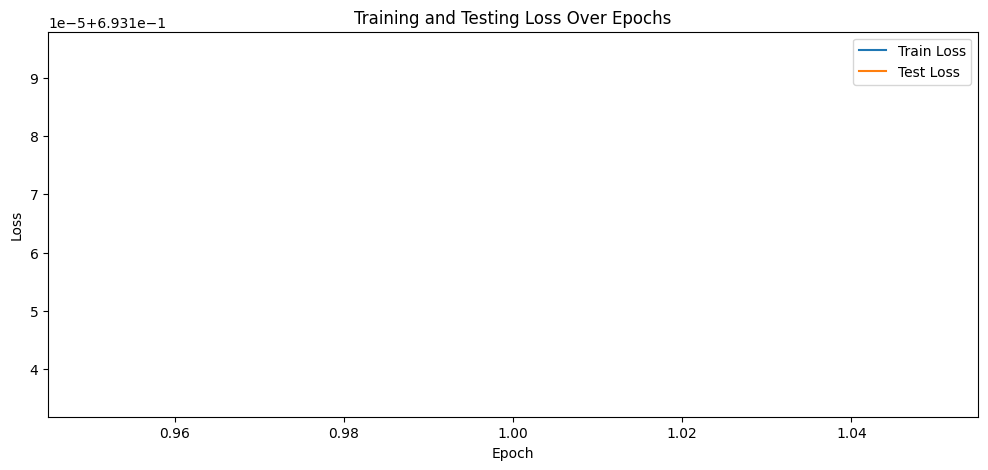

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.04333009570837021
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 2/100, Train Loss: 0.693128822469231, Test Loss: 0.6931970135385621


<Figure size 640x480 with 0 Axes>

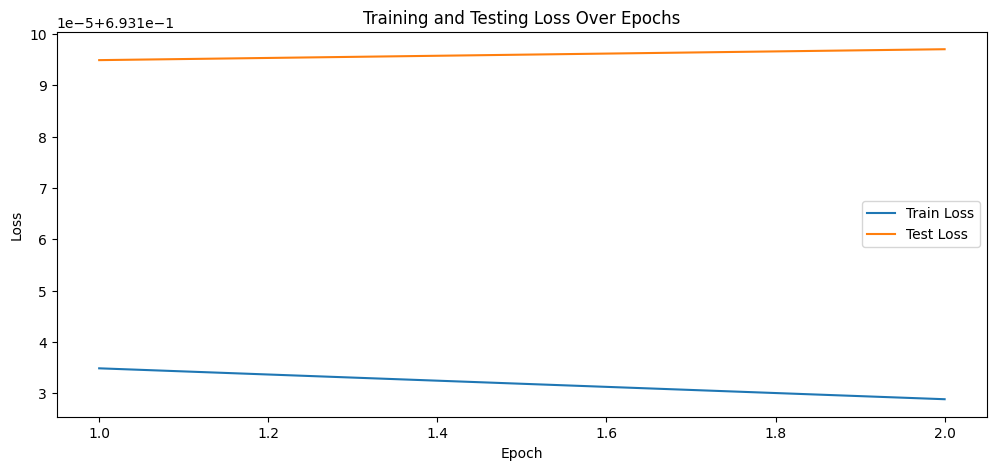

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.043330129235982895
Inside testing loop. Batch indices: 0, loss value: inf
Model saved as 'model_input20_target2_dmodel64_nheads2_encoderlayers2_lstmhidden64_lstmlayers2.pth' at Epoch 3
Epoch 3/100, Train Loss: 0.6931253313555357, Test Loss: 0.6931922887960333


<Figure size 640x480 with 0 Axes>

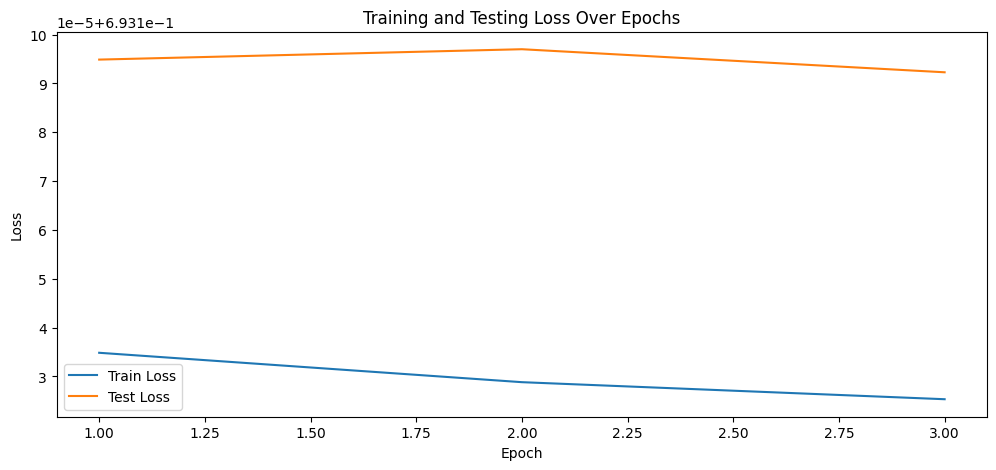

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0433303639292717
Inside testing loop. Batch indices: 0, loss value: inf
Model saved as 'model_input20_target2_dmodel64_nheads2_encoderlayers2_lstmhidden64_lstmlayers2.pth' at Epoch 4
Epoch 4/100, Train Loss: 0.6931342602991216, Test Loss: 0.693185634619666


<Figure size 640x480 with 0 Axes>

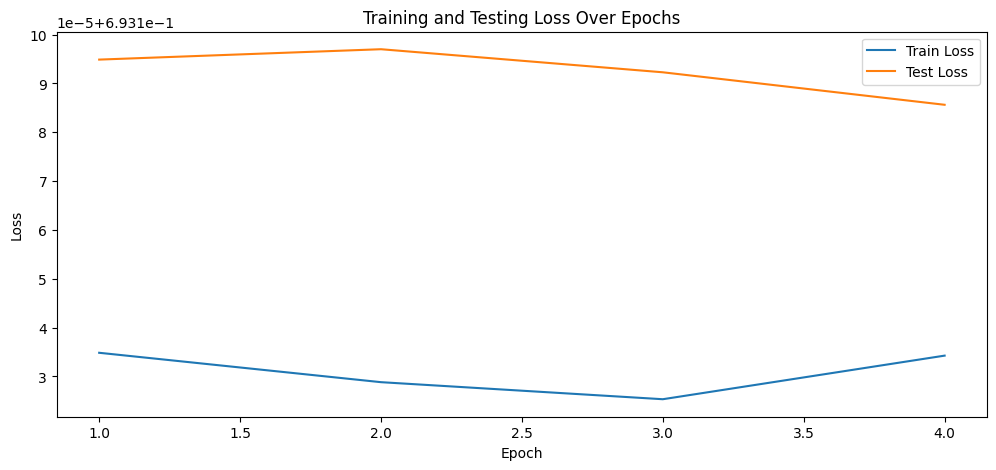

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.043330397456884384
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 5/100, Train Loss: 0.6931367551089924, Test Loss: 0.6931964891723619


<Figure size 640x480 with 0 Axes>

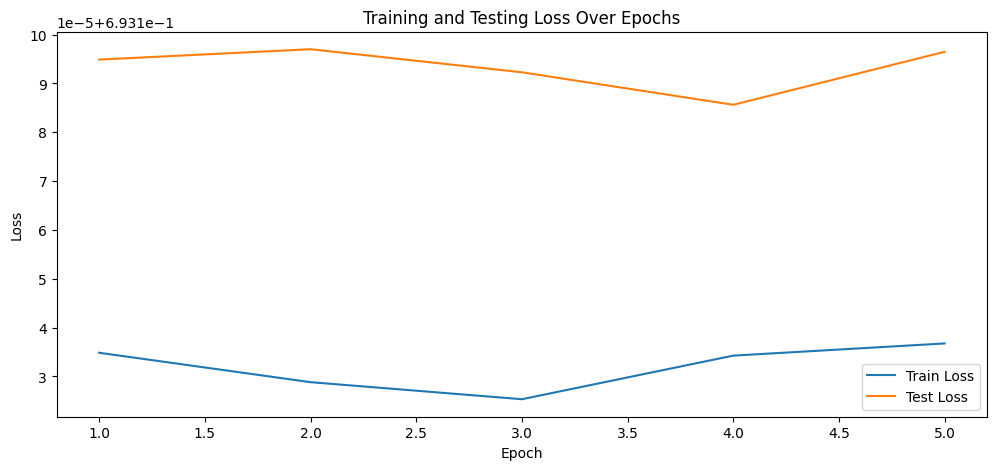

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.04333040490746498
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 6/100, Train Loss: 0.6931355952088252, Test Loss: 0.6931950529048131


<Figure size 640x480 with 0 Axes>

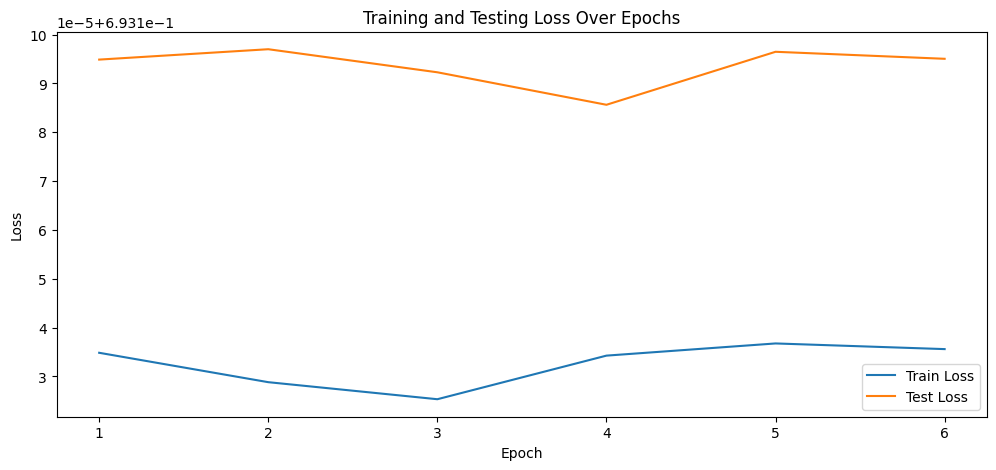

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0433303564786911
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 7/100, Train Loss: 0.6931319226050981, Test Loss: 0.6931922394771947


<Figure size 640x480 with 0 Axes>

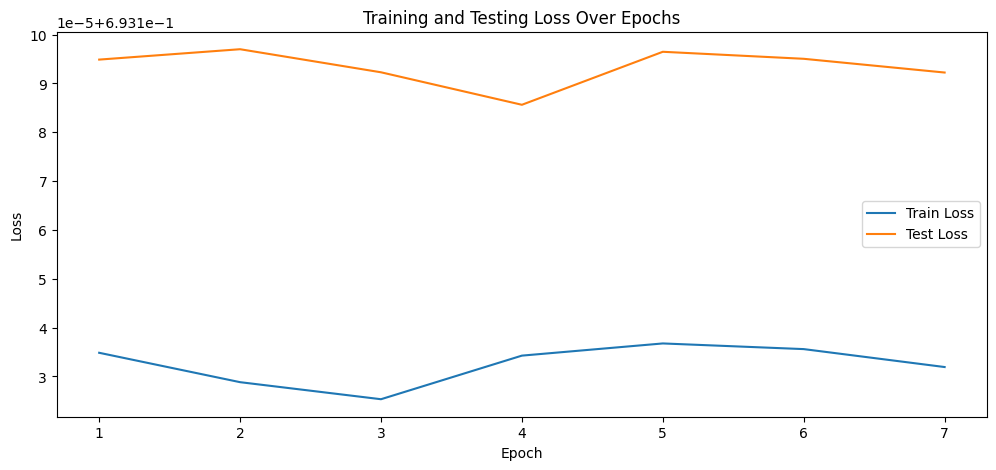

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.04333007335662842
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 8/100, Train Loss: 0.6931313207435631, Test Loss: 0.6931863493892857


<Figure size 640x480 with 0 Axes>

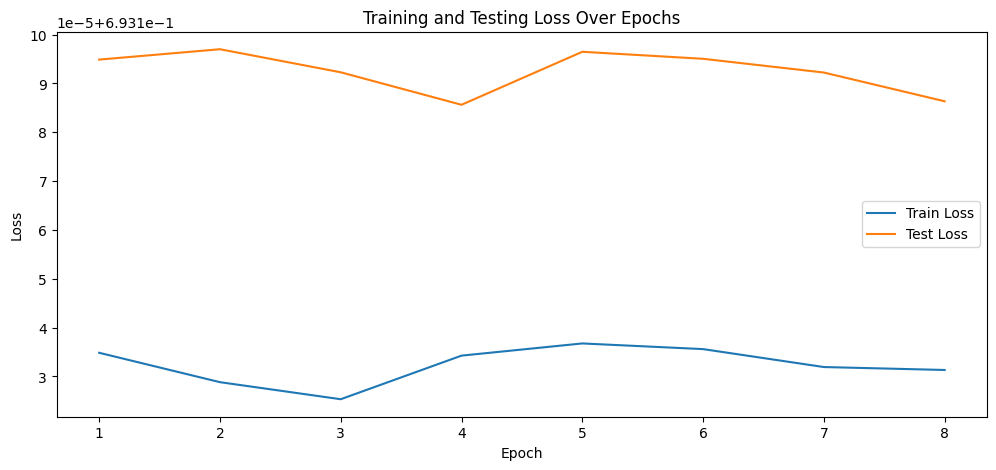

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.04333047196269035
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 9/100, Train Loss: 0.6931354178703608, Test Loss: 0.6931895277144403


<Figure size 640x480 with 0 Axes>

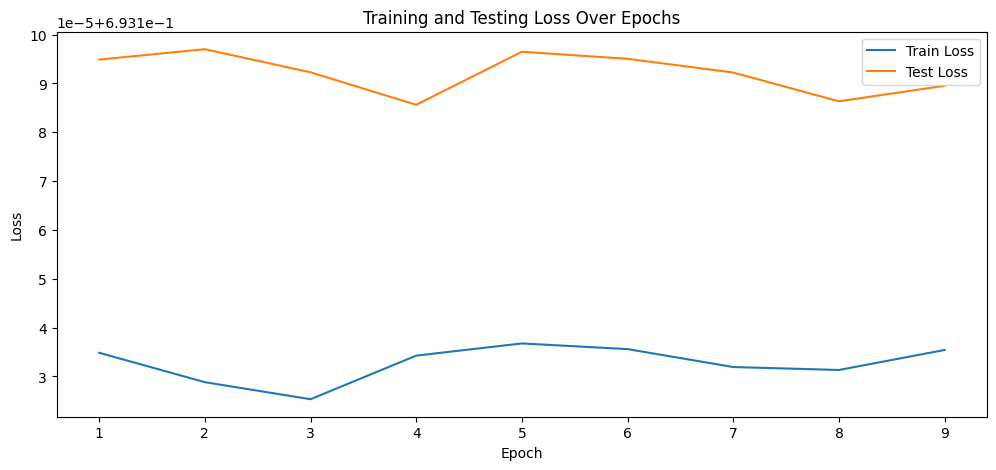

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.04332992061972618
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 10/100, Train Loss: 0.6931260366807819, Test Loss: 0.6931905150413513


<Figure size 640x480 with 0 Axes>

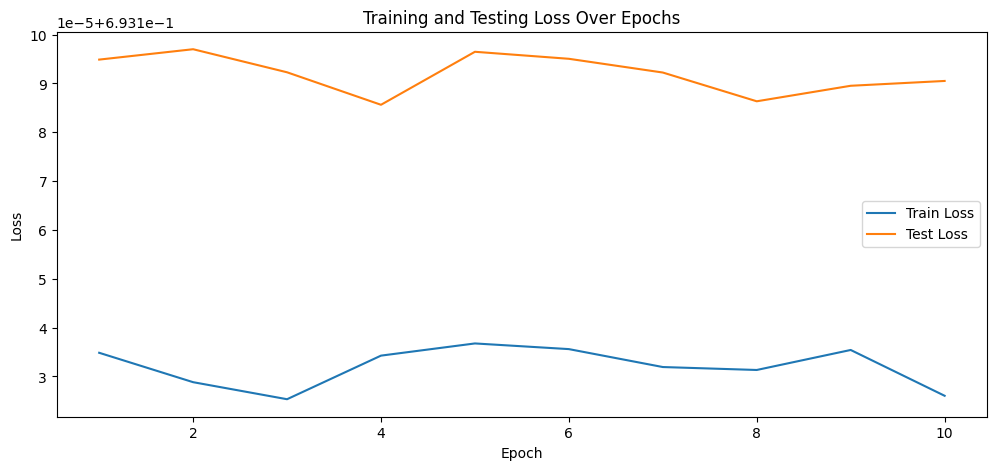

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.04333072528243065
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 11/100, Train Loss: 0.6931396166526957, Test Loss: 0.6931899051736968


<Figure size 640x480 with 0 Axes>

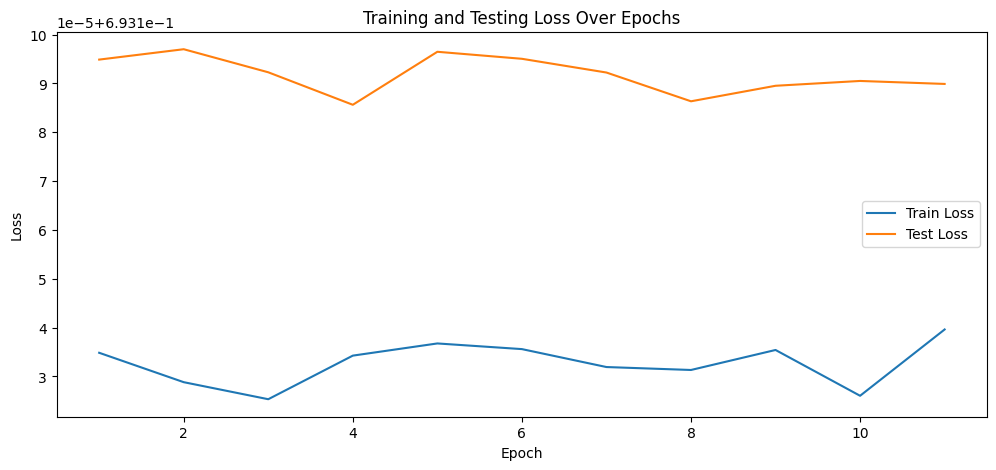

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.04333070293068886
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 12/100, Train Loss: 0.6931377803291341, Test Loss: 0.6931877294108203


<Figure size 640x480 with 0 Axes>

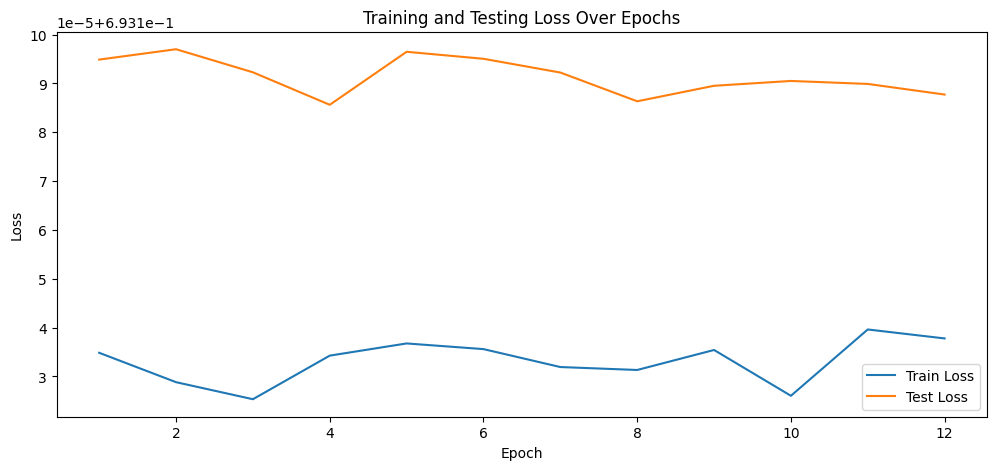

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.04333028569817543
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 13/100, Train Loss: 0.6931335325597516, Test Loss: 0.6931970460531997


<Figure size 640x480 with 0 Axes>

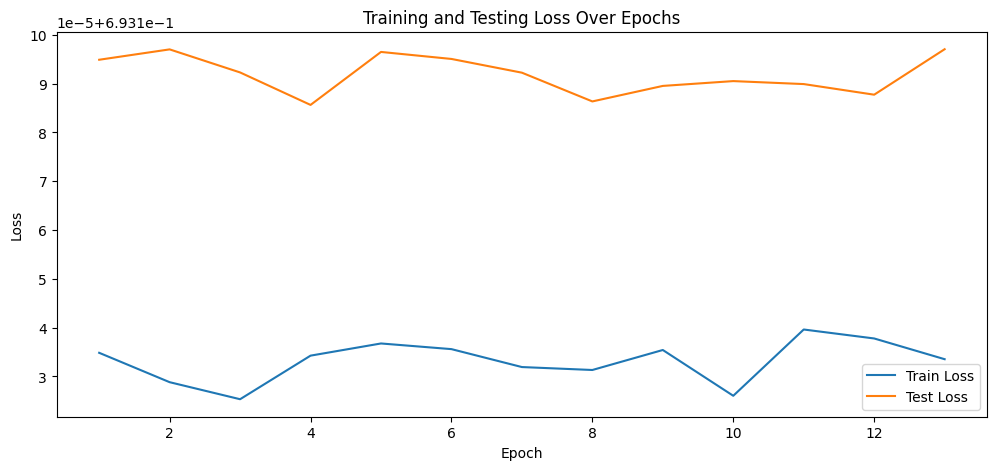

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.04333015903830528
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 14/100, Train Loss: 0.6931315053147231, Test Loss: 0.6931946786274172


<Figure size 640x480 with 0 Axes>

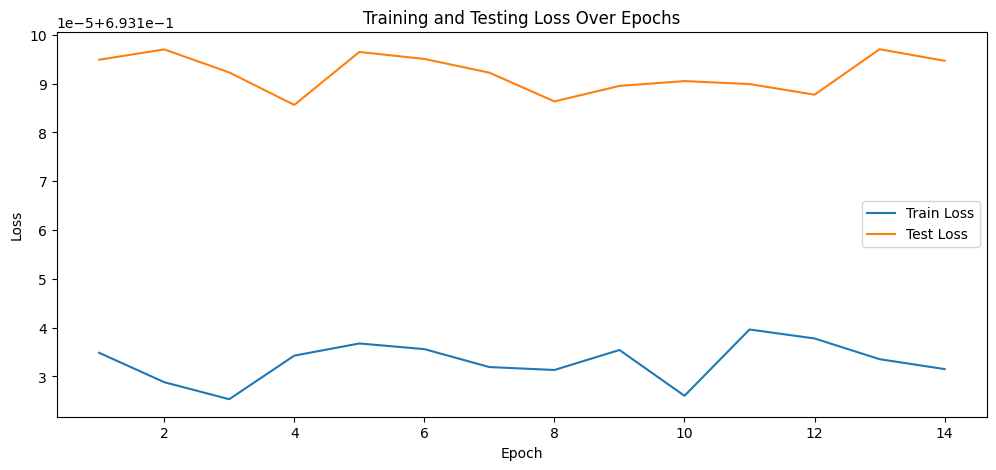

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.043330393731594086
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 15/100, Train Loss: 0.6931309083424904, Test Loss: 0.6931877037239251


<Figure size 640x480 with 0 Axes>

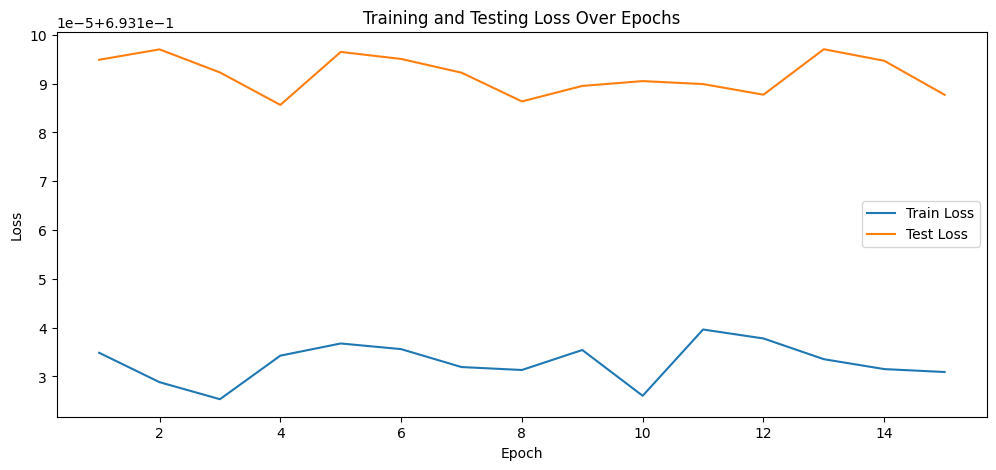

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.043329961597919464
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 16/100, Train Loss: 0.6931301974336032, Test Loss: 0.6931967925207829


<Figure size 640x480 with 0 Axes>

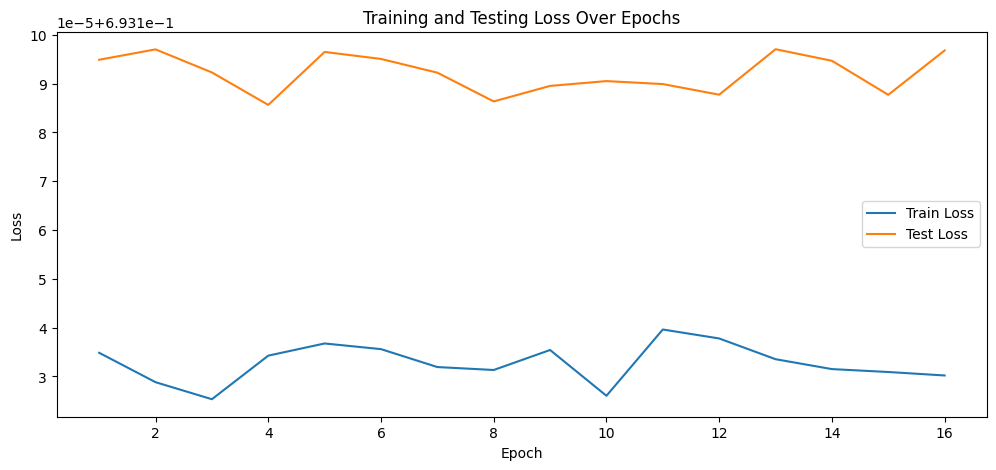

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0433308482170105
Inside testing loop. Batch indices: 0, loss value: inf
Model saved as 'model_input20_target2_dmodel64_nheads2_encoderlayers2_lstmhidden64_lstmlayers2.pth' at Epoch 17
Epoch 17/100, Train Loss: 0.6931403469813707, Test Loss: 0.6931791388844869


<Figure size 640x480 with 0 Axes>

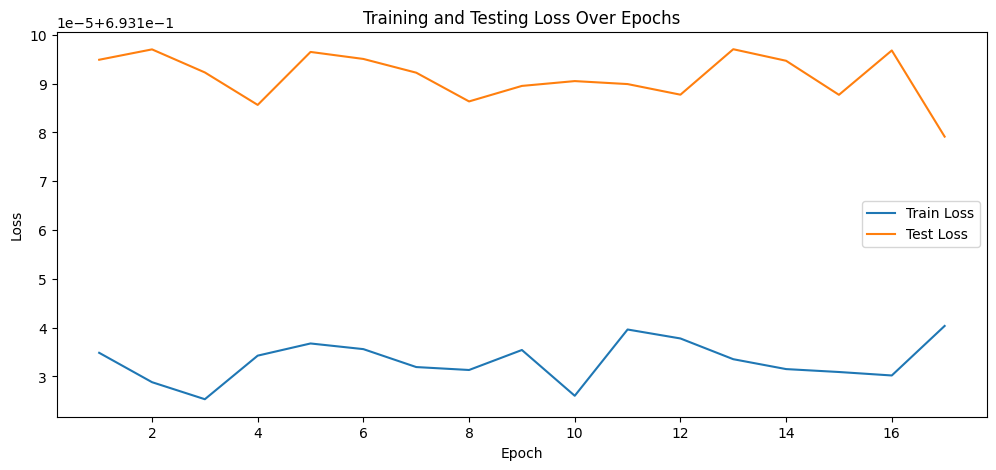

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.043330706655979156
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 18/100, Train Loss: 0.693136436139882, Test Loss: 0.6931948701798418


<Figure size 640x480 with 0 Axes>

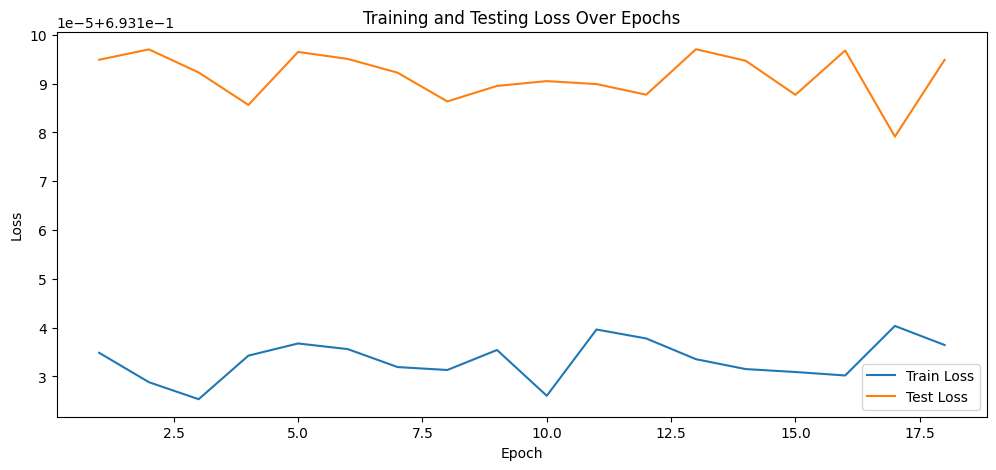

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.04333031550049782
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 19/100, Train Loss: 0.6931323984224462, Test Loss: 0.6931889828208202


<Figure size 640x480 with 0 Axes>

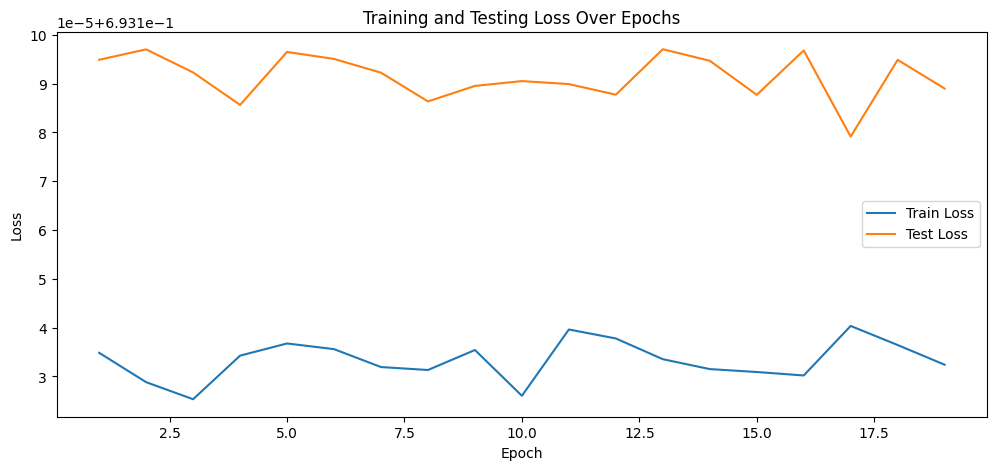

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.04333029314875603
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 20/100, Train Loss: 0.6931339002772307, Test Loss: 0.6931904013450771


<Figure size 640x480 with 0 Axes>

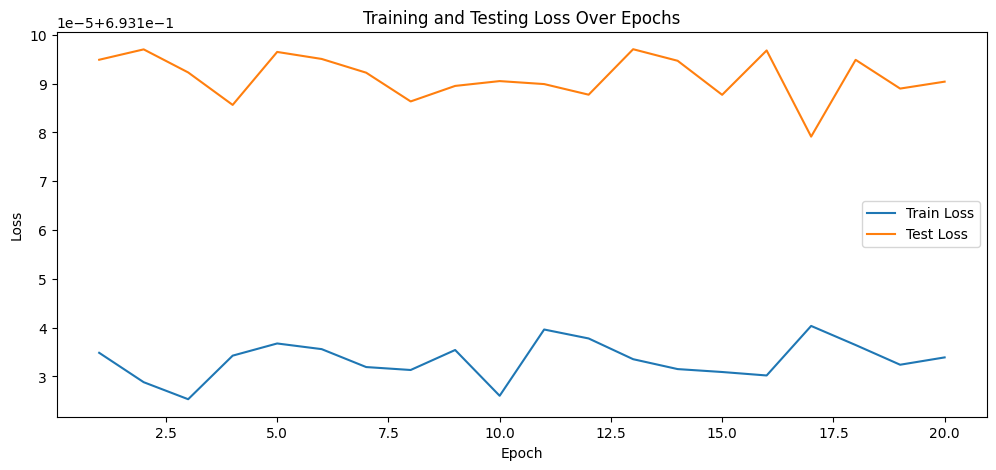

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.04332975298166275
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 21/100, Train Loss: 0.693126713964867, Test Loss: 0.6931945740127033


<Figure size 640x480 with 0 Axes>

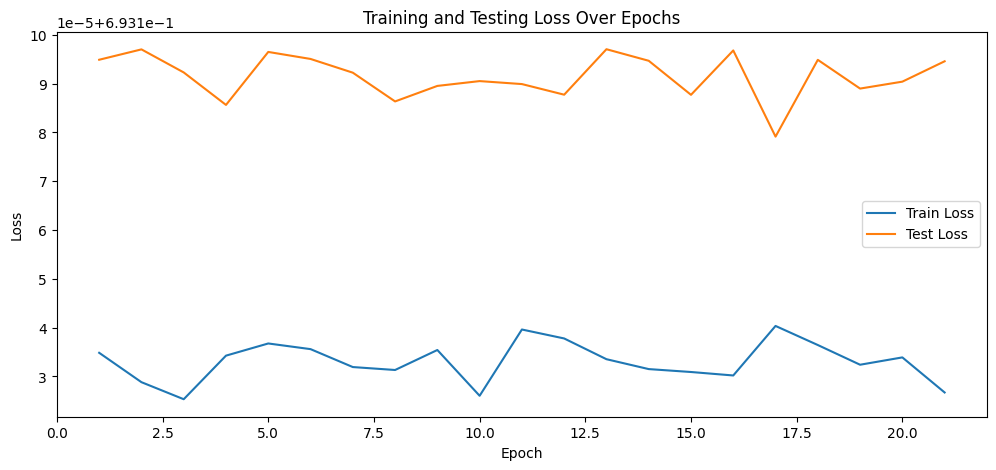

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.043330684304237366
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 22/100, Train Loss: 0.6931385722731433, Test Loss: 0.6931884881740814


<Figure size 640x480 with 0 Axes>

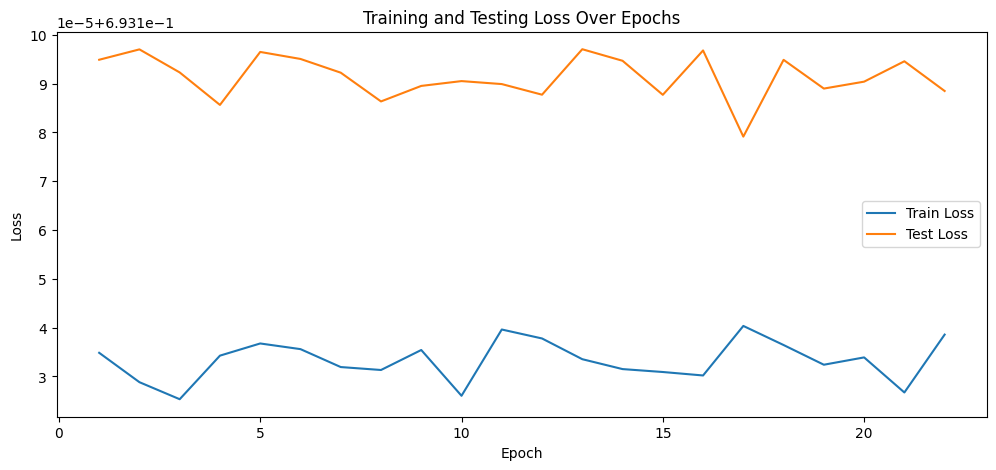

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.043330077081918716
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 23/100, Train Loss: 0.6931307554433045, Test Loss: 0.6931895552353244


<Figure size 640x480 with 0 Axes>

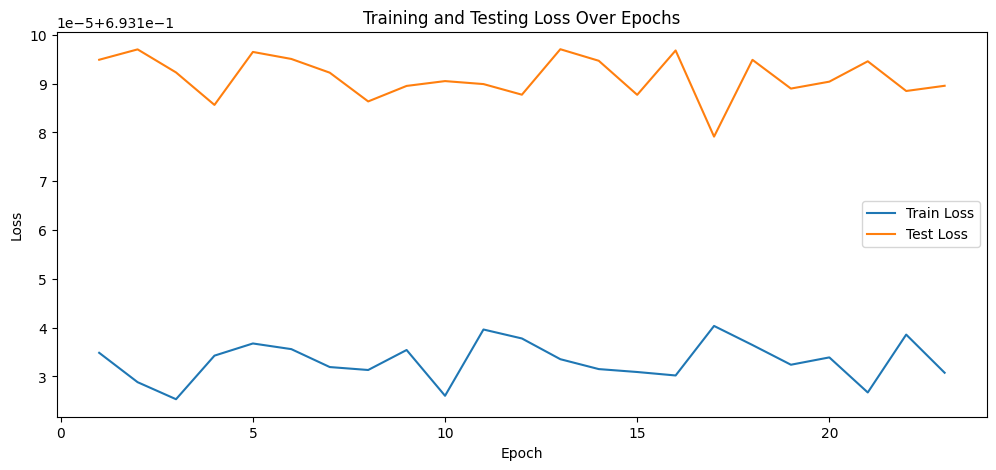

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.043330516666173935
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 24/100, Train Loss: 0.6931346105785715, Test Loss: 0.6931876521070761


<Figure size 640x480 with 0 Axes>

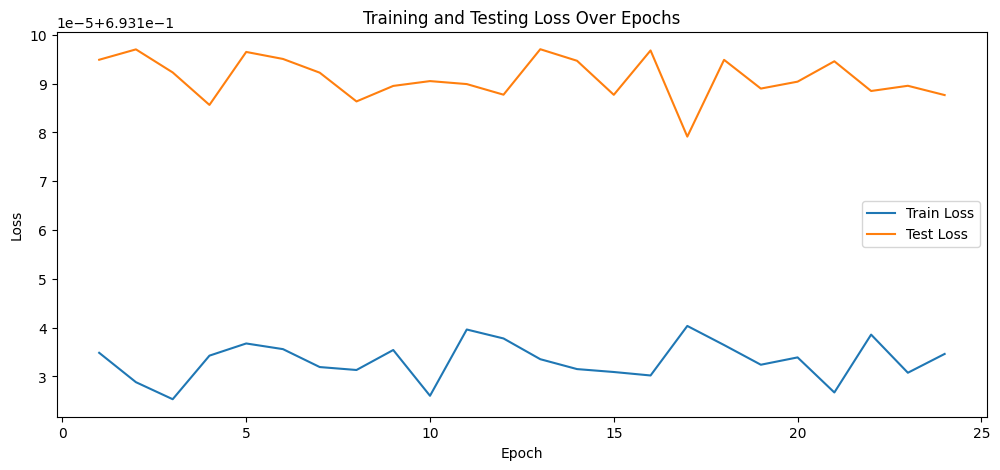

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.04333039000630379
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 25/100, Train Loss: 0.6931314959483823, Test Loss: 0.6931926922404843


<Figure size 640x480 with 0 Axes>

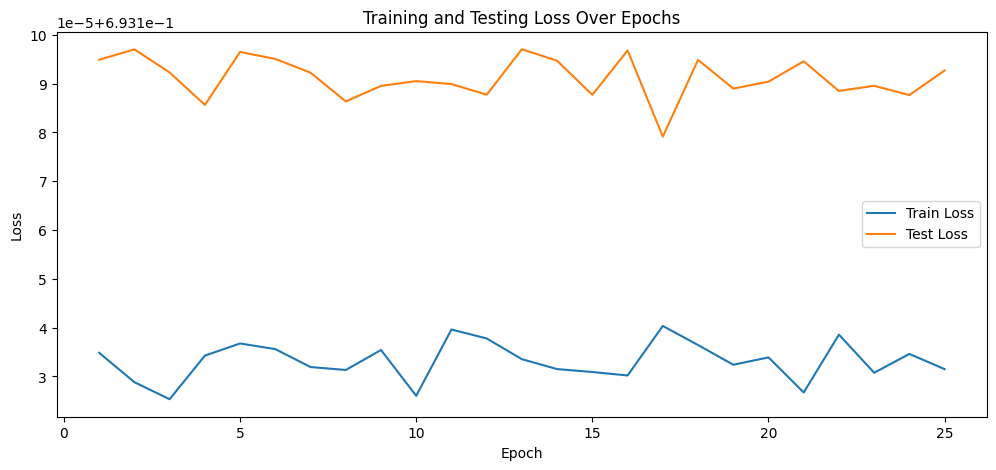

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.04332996532320976
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 26/100, Train Loss: 0.6931265372267164, Test Loss: 0.6931951518407897


<Figure size 640x480 with 0 Axes>

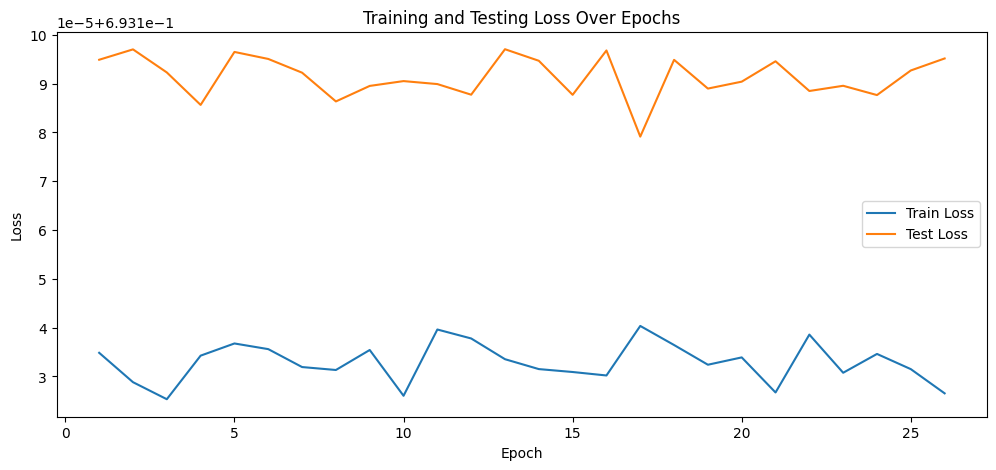

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.04333039000630379
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 27/100, Train Loss: 0.6931321625353106, Test Loss: 0.6931874390660446


<Figure size 640x480 with 0 Axes>

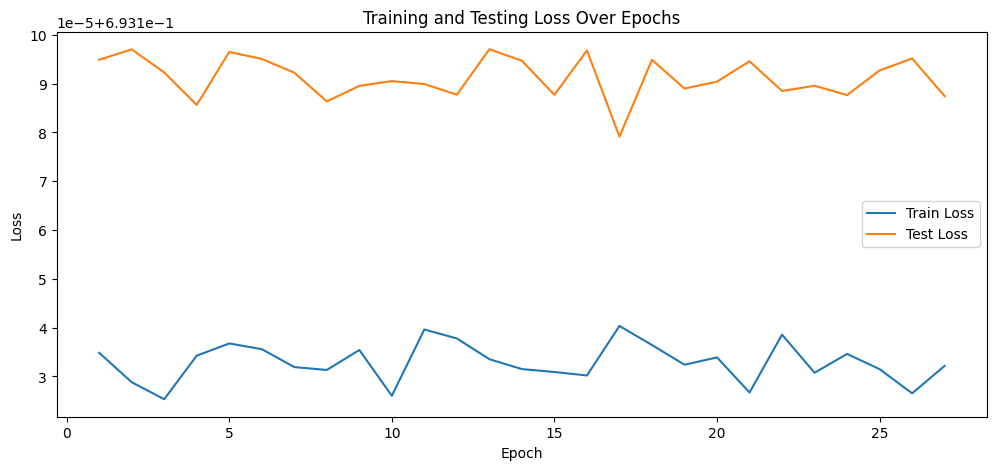

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.04333040863275528
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 28/100, Train Loss: 0.6931326878387624, Test Loss: 0.6931827819159564


<Figure size 640x480 with 0 Axes>

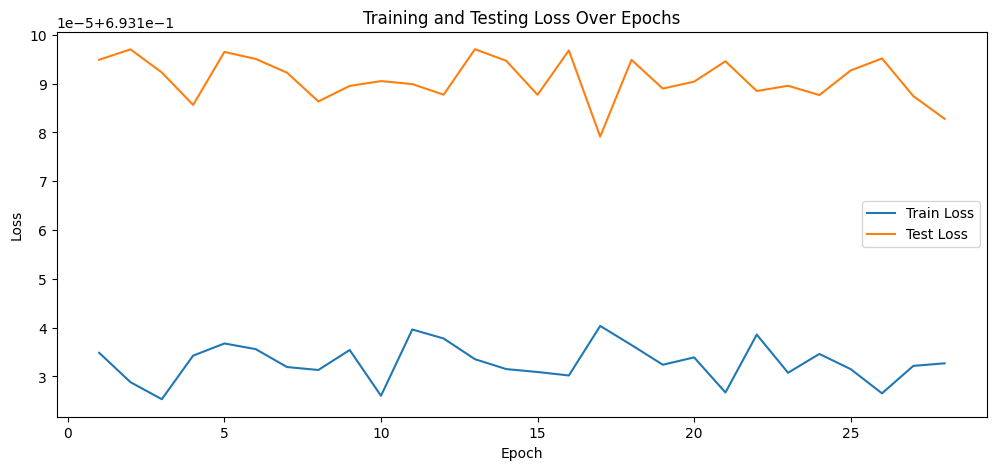

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.04333042353391647
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 29/100, Train Loss: 0.693139918588808, Test Loss: 0.6931934818832602


<Figure size 640x480 with 0 Axes>

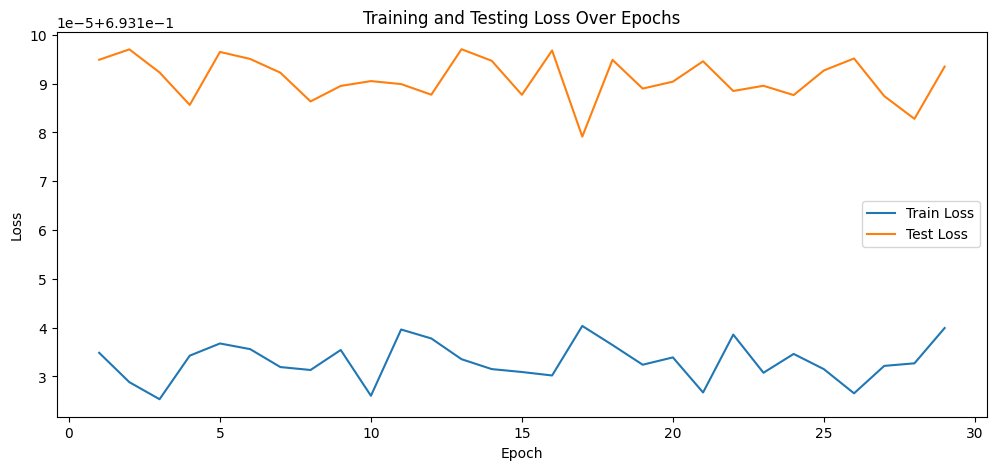

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.04333026334643364
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 30/100, Train Loss: 0.6931335514515526, Test Loss: 0.6931932143307704


<Figure size 640x480 with 0 Axes>

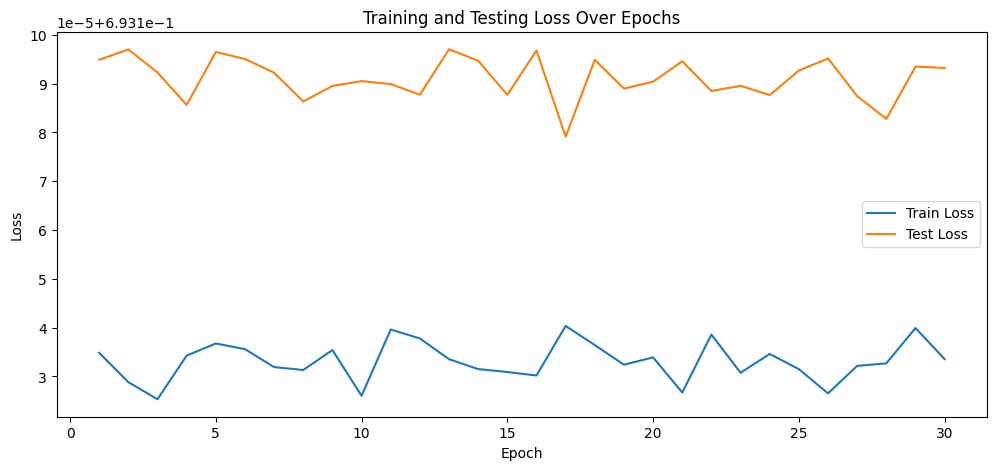

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.04333029314875603
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 31/100, Train Loss: 0.6931331162602559, Test Loss: 0.6931838383709975


<Figure size 640x480 with 0 Axes>

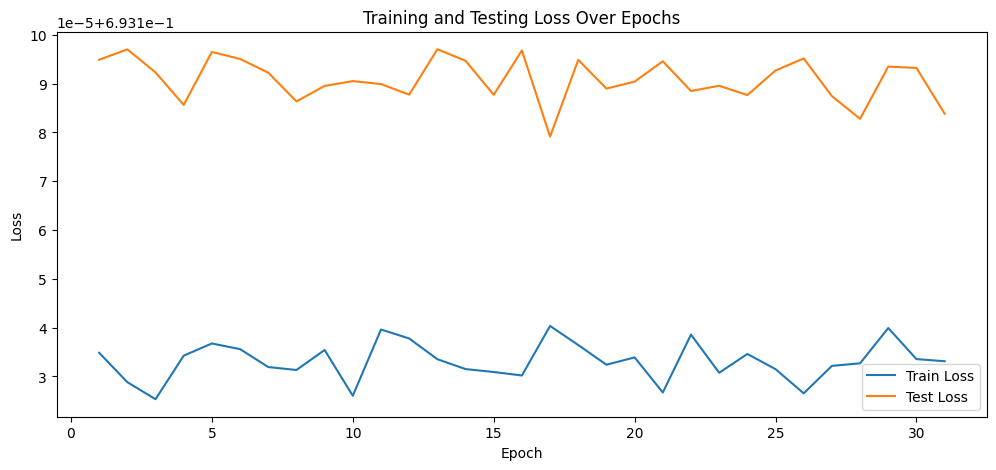

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.043330106884241104
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 32/100, Train Loss: 0.6931303677563528, Test Loss: 0.6931922886192633


<Figure size 640x480 with 0 Axes>

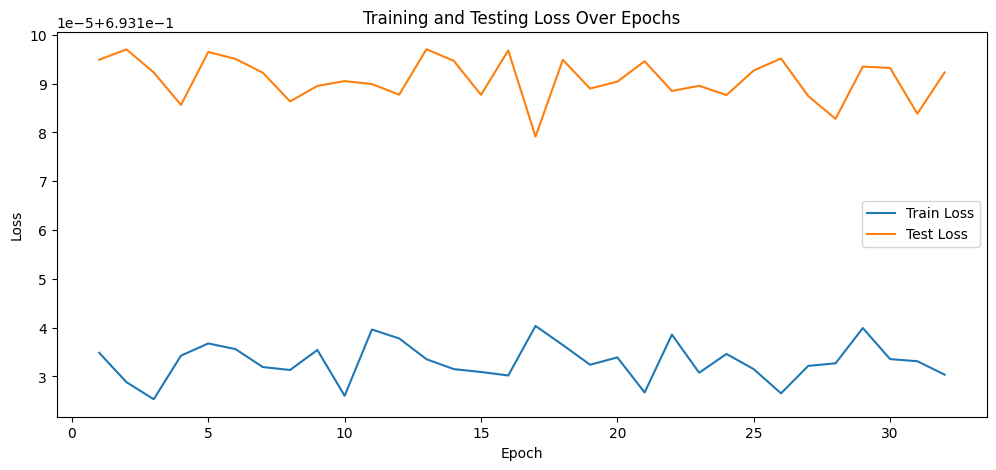

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.04333047196269035
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 33/100, Train Loss: 0.6931364150204107, Test Loss: 0.6931848661892938


<Figure size 640x480 with 0 Axes>

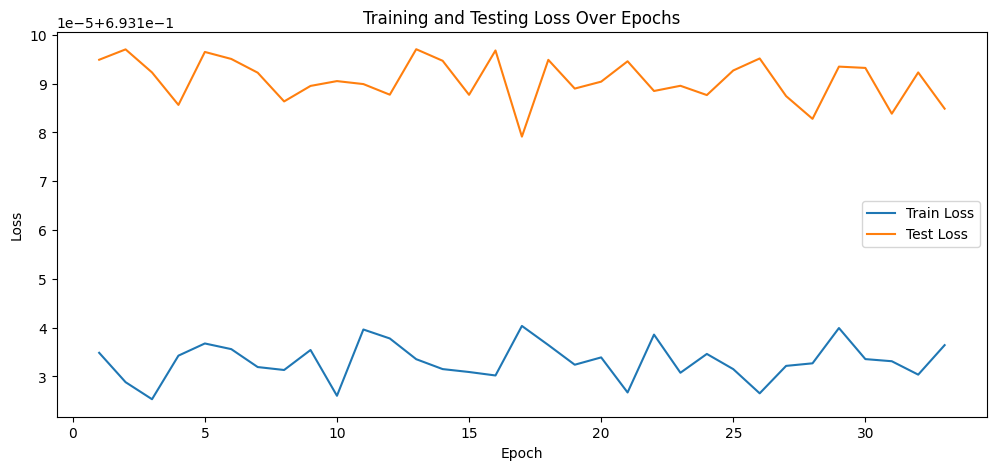

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.043330151587724686
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 34/100, Train Loss: 0.6931291559254309, Test Loss: 0.6931914919940712


<Figure size 640x480 with 0 Axes>

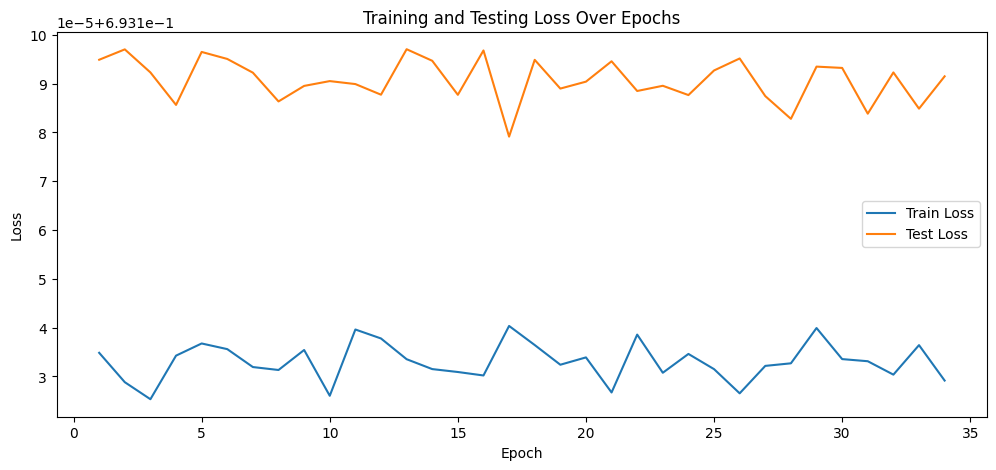

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.04333057627081871
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 35/100, Train Loss: 0.693133357839523, Test Loss: 0.6931973956048876


<Figure size 640x480 with 0 Axes>

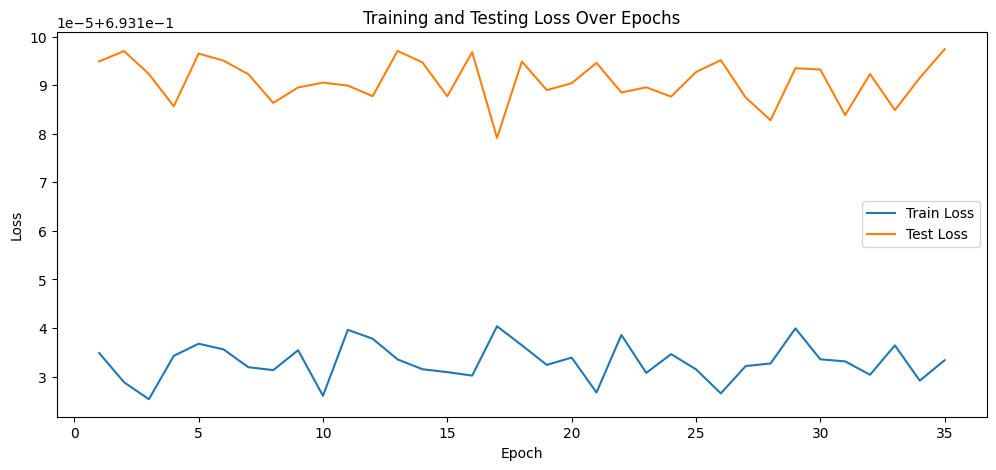

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.04332980513572693
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 36/100, Train Loss: 0.6931227773822145, Test Loss: 0.6931972165037019


<Figure size 640x480 with 0 Axes>

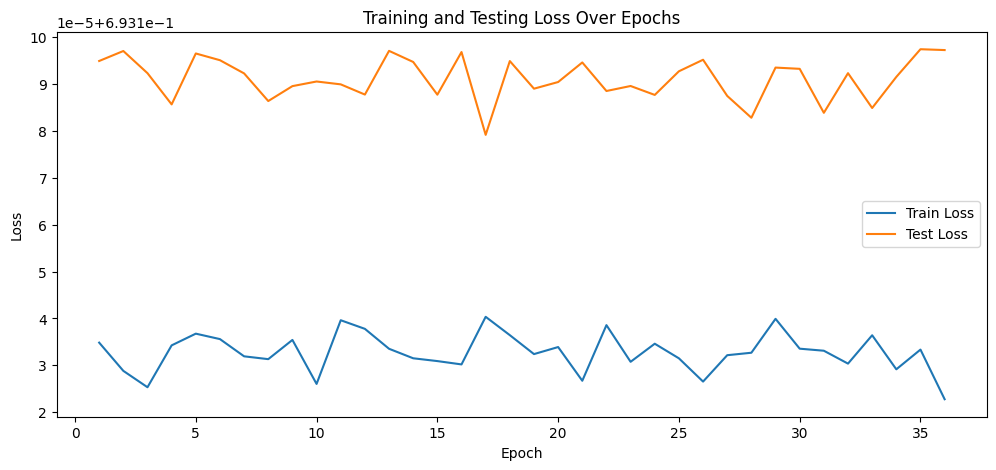

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.04333029314875603
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 37/100, Train Loss: 0.6931317105858581, Test Loss: 0.6931915228072971


<Figure size 640x480 with 0 Axes>

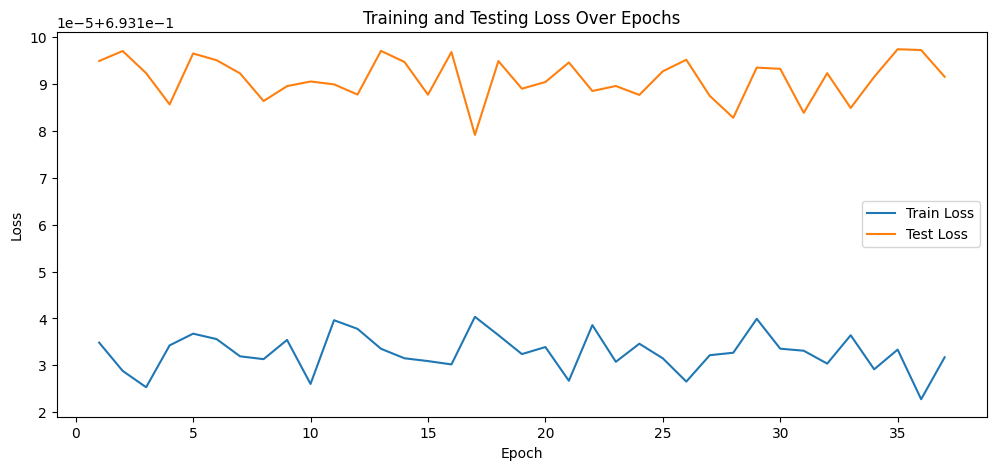

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.04333074763417244
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 38/100, Train Loss: 0.6931372944872698, Test Loss: 0.6931938144318808


<Figure size 640x480 with 0 Axes>

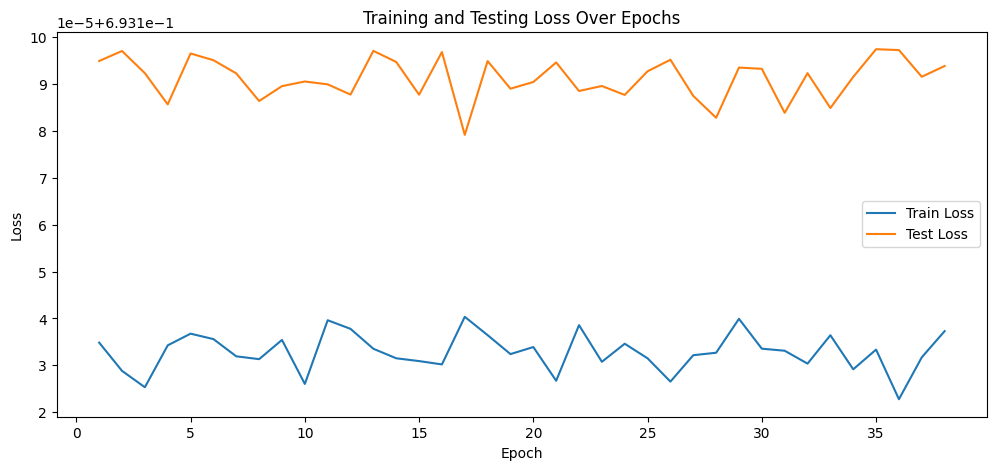

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.043330561369657516
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 39/100, Train Loss: 0.6931344479369446, Test Loss: 0.6931883681251342


<Figure size 640x480 with 0 Axes>

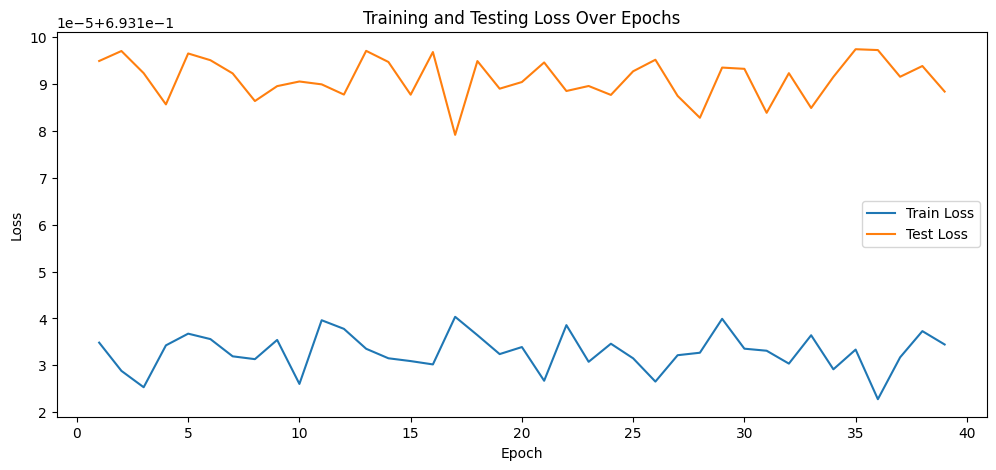

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.04333027824759483
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 40/100, Train Loss: 0.6931364218046793, Test Loss: 0.6931944298677913


<Figure size 640x480 with 0 Axes>

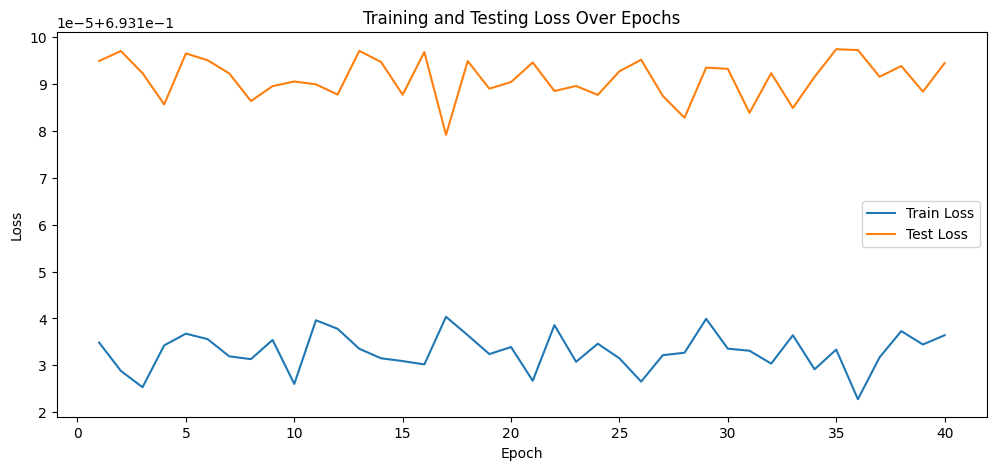

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0433296374976635
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 41/100, Train Loss: 0.6931273592515067, Test Loss: 0.6931863292043579


<Figure size 640x480 with 0 Axes>

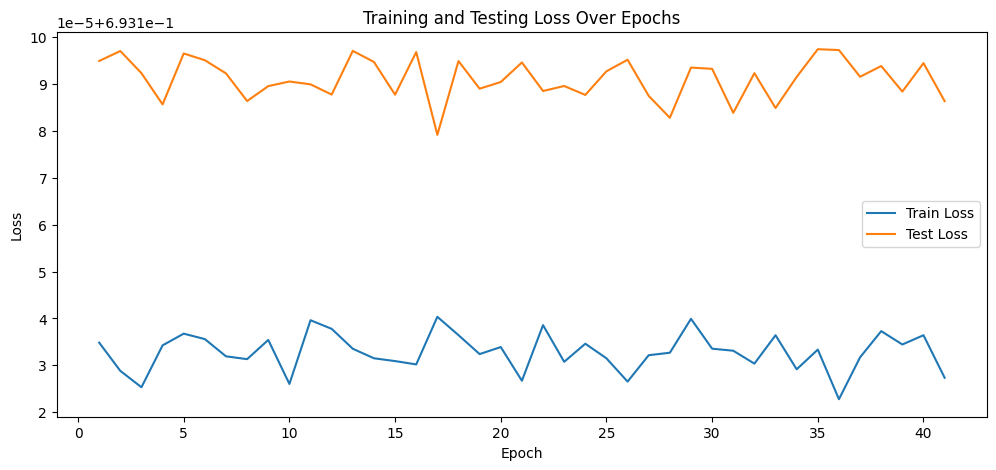

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.043330155313014984
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 42/100, Train Loss: 0.6931361092292717, Test Loss: 0.6931901358806832


<Figure size 640x480 with 0 Axes>

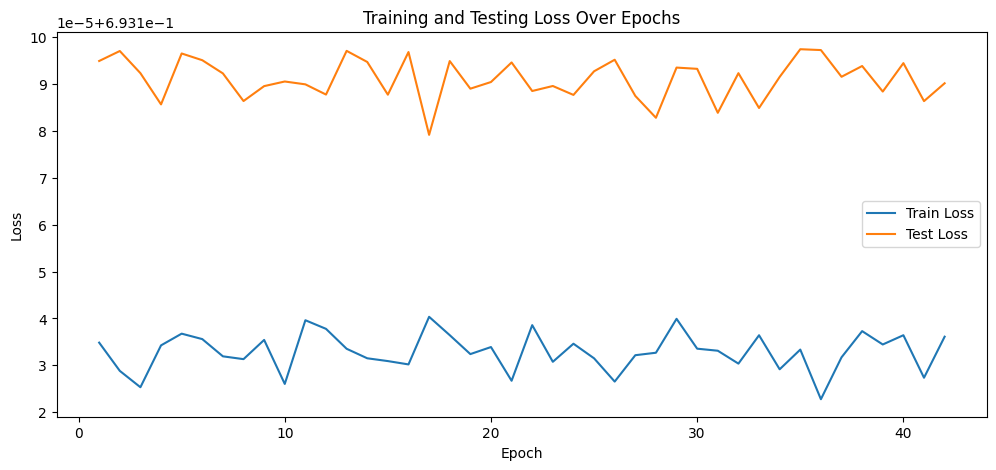

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.043330222368240356
Inside testing loop. Batch indices: 0, loss value: inf


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [296]:
def create_model_filename(input_size, target_size, d_model, n_heads, num_encoder_layers, lstm_hidden_size, num_lstm_layers):
    return f"model_input{input_size}_target{target_size}_dmodel{d_model}_nheads{n_heads}_encoderlayers{num_encoder_layers}_lstmhidden{lstm_hidden_size}_lstmlayers{num_lstm_layers}.pth"

# 모델 파일 경로
model_file_path = f"model/{create_model_filename(input_size, target_size, d_model, n_heads, num_encoder_layers, lstm_hidden_size, num_lstm_layers)}"

# 모델 파일이 존재하는지 확인하고, 존재할 경우 모델 로드
if os.path.isfile(model_file_path):
    model.load_state_dict(torch.load(model_file_path))
    print("Pre-trained model loaded.")
else:
    print("No pre-trained model found. Initializing a new model.")

# 학습 과정
train_losses = []
test_losses = []
best_test_loss = float('inf')

# Define the directory for saving figures
figures_directory = "figures"
model_name = create_model_filename(input_size, target_size, d_model, n_heads, num_encoder_layers, lstm_hidden_size, num_lstm_layers).replace('.pth', '')  # Use the generated model name without the file extension
model_figures_directory = os.path.join(figures_directory, model_name)

# Create the directories if they do not exist
os.makedirs(model_figures_directory, exist_ok=True)

for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, criterion)
    test_loss = test(model, test_loader, criterion)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    # Update best test loss and save model
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model.state_dict(), model_file_path)
        print(f"Model saved as '{create_model_filename(input_size, target_size, d_model, n_heads, num_encoder_layers, lstm_hidden_size, num_lstm_layers)}' at Epoch {epoch + 1}")

    # Print epoch results
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss}, Test Loss: {test_loss}")


    # Plotting
    plt.figure(figsize=(12, 5))

    # 학습 과정 시각화
    plt.plot(range(1, epoch + 2), train_losses, label='Train Loss')
    plt.plot(range(1, epoch + 2), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Testing Loss Over Epochs')
    plt.legend()

    # Save the figure before calling show
    figure_path = os.path.join(model_figures_directory, f"Epoch_{epoch+1}.png")
    plt.savefig(figure_path)

    # Then display the plot
    plt.show()

    # Clear the figure after displaying it to prepare for the next plot if this is not the last epoch
    plt.clf()




    # # Plot training loss
    # plt.subplot(1, 2, 1)
    # plt.plot(range(1, epoch + 2), train_losses, label='Train Loss')
    # plt.xlabel('Epoch')
    # plt.ylabel('Loss')
    # plt.title('Training Loss Over Epochs')
    # plt.legend()

    # # Plot testing loss
    # plt.subplot(1, 2, 2)
    # plt.plot(range(1, epoch + 2), test_losses, label='Test Loss')
    # plt.xlabel('Epoch')
    # plt.ylabel('Loss')
    # plt.title('Testing Loss Over Epochs')
    # plt.legend()

    # plt.tight_layout()
    # plt.show()